# Autoencoder

In [1]:
import time
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm.notebook import trange
from util import topk_acc

In [2]:
import importlib
import util
importlib.reload(util)

<module 'util' from 'c:\\Users\\wang\\Desktop\\URECA\\src\\util.py'>

In [3]:
torch.manual_seed(0)
random.seed(0)

In [11]:
device = torch.device("cuda")

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# 550s
data_pt = torch.load('./data/auto_c.pt')

In [6]:
num = len(data_pt)

# Autoencoder

In [7]:
train_set, dev_set = torch.utils.data.random_split(data_pt, [int(num * 0.99), int(num * 0.01)])
datasets = {'train':train_set, 'dev':dev_set}
dataset_sizes = {x:len(datasets[x]) for x in ['train', 'dev']} 
dataloaders = {x:torch.utils.data.DataLoader(datasets[x], batch_size=1024, shuffle=True, pin_memory=True) for x in ['train', 'dev']} 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            self.fc_block(773, 600),
            self.fc_block(600, 400),
            self.fc_block(400, 200),
            self.fc_block(200, 100),
            )
        self.decoder = nn.Sequential(
            self.fc_block(100, 200),
            self.fc_block(200, 400),
            self.fc_block(400, 600),
            self.fc_block(600, 773, final_layer=True),
            )
    def fc_block(self, input_dims, output_dims, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                    nn.Linear(input_dims, output_dims),
                    nn.Dropout(0.1),
                    nn.Tanh(),
                    )
        else:
            return nn.Sequential(
                    nn.Linear(input_dims, output_dims),
                    nn.Dropout(0.1),
                    nn.Sigmoid(),
                    )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

net = Autoencoder().to(device)

In [ ]:
net.load_state_dict(torch.load('./model/autoencoder.pt'))

# Autoencoder

In [ ]:
sta = {x:{'epoch_loss':[]} for x in ['train', 'dev']}

In [ ]:
num_epochs = 20

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 4, eta_min=1e-5, last_epoch=-1)
# warm_up = lambda epoch: epoch / warm_up_epochs if epoch <= warm_up_epochs else 0.5 * (math.cos((epoch - warm_up_epochs) / (num_epochs - warm_up_epochs) * math.pi) + 1)
# scheduler = tWorch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warm_up)

In [ ]:
best_loss = 100

In [ ]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  # Set model to training mode
        else:
            net.eval()   # Set model to evaluate mode

        running_loss = 0.0

        for batch in dataloaders[phase]:
            
            inputs = batch[0].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, inputs)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]

        # statistics
        sta[phase]['epoch_loss'].append(epoch_loss)
        if phase == 'dev':
            print(epoch_loss, time.strftime("%H:%M:%S", time.localtime()))

        if phase == 'dev' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_net_wts = copy.deepcopy(net.state_dict())

In [ ]:
net.load_state_dict(best_net_wts)

In [ ]:
def plot_sta(sta: dict, interval: int = None, title: str = None) -> None:
    """plot the statistics from the dictionary"""
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title, fontsize=14)
    epochs = len(sta['train']['epoch_loss'])
    # plot loss
    t_loss = sta['train']['epoch_loss']
    d_loss = sta['dev']['epoch_loss']
    ax = plt.subplot(122)
    tlline, = plt.plot(np.append(np.roll(t_loss, 1), t_loss[epochs - 1]), color='g')
    dlline, = plt.plot(np.append(np.roll(d_loss, 1), d_loss[epochs - 1]), linestyle=":", color='r')
    plt.grid(color="k", linestyle=":")
    plt.legend((tlline, dlline), ('train', 'dev'))
    plt.ylabel('loss')
    plt.xlabel('iterations')
    ax.set_xlim(1, epochs)
    if interval is not None:
        dim = np.arange(1, epochs + 1, interval)
        plt.xticks(dim)

    plt.show()

In [ ]:
min(sta['dev']['epoch_loss'])

In [ ]:
plot_sta(sta)

In [ ]:
torch.save(net.state_dict(), './model/autoencoder.pt')

In [ ]:
torch.save(sta, './model/ae_loss.pt')

# Classification

In [8]:
train_set, dev_set, test_set = torch.utils.data.random_split(data_pt, [int(num * 0.98), int(num * 0.01), int(num * 0.01)])
datasets = {'train':train_set, 'dev':dev_set, 'test':test_set}
dataset_sizes = {x:len(datasets[x]) for x in ['train', 'dev','test']} 
dataloaders = {x:torch.utils.data.DataLoader(datasets[x], batch_size=1024,
shuffle=True, pin_memory=True) for x in ['train', 'dev', 'test']} 

## autoencoder classifier

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            self.fc_block_t(773, 600),
            self.fc_block_t(600, 400),
            self.fc_block_t(400, 200),
            self.fc_block_t(200, 100),
            )
        self.fc = nn.Sequential(
            self.fc_block_r(100, 1024),   
            self.fc_block_r(1024, 512),  
            self.fc_block_r(512, 256),
            self.fc_block_r(256, 7, final_layer=True)
        )

    def fc_block_t(self, in_dim, out_dim, dropout=0.1):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout),
            nn.Tanh())

    def fc_block_r(self, in_dim, out_dim, dropout=0.25, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.Dropout(dropout),
                nn.ReLU(True)
            )
        else:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
            )
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        return x

net = Classifier().to(device)
net.load_state_dict(torch.load('./model/autoencoder.pt'))

RuntimeError: Error(s) in loading state_dict for Classifier:
	Missing key(s) in state_dict: "fc.0.1.weight", "fc.0.1.bias", "fc.1.1.weight", "fc.1.1.bias", "fc.2.0.weight", "fc.2.0.bias". 
	Unexpected key(s) in state_dict: "decoder.0.0.weight", "decoder.0.0.bias", "decoder.1.0.weight", "decoder.1.0.bias", "decoder.2.0.weight", "decoder.2.0.bias", "decoder.3.0.weight", "decoder.3.0.bias". 

## trivial classifier

adam 1e-3 0.99 40

In [53]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            self.fc_block(773, 1024, dropout=0.5),
            self.fc_block(1024, 512, dropout=0.3),
            self.fc_block(512, 256, dropout=0.1),
            self.fc_block(256, 7, dropout=0, final_layer=True),
            )

    def fc_block(self, in_dim, out_dim, dropout=0.1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.Dropout(dropout),
                nn.ReLU(True)
            )
        else:
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.Dropout(dropout)
            )
    def forward(self, x):
        x = self.fc(x)
        return x

net = Classifier().to(device)

In [54]:
sta = {x:{'epoch_acc':[], 'epoch_loss':[]} for x in ['train', 'dev']}

In [55]:
best_acc = 1 / 7

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
# scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.8)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 1e-5)

In [57]:
num_epochs = 100

In [59]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  
        else:
            net.eval()   
        running_loss = 0.0
        running_corrects = 0
        for batch in dataloaders[phase]:
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                top_acc = topk_acc(outputs, labels, 2)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += top_acc

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]


        # statistics recording
        sta[phase]['epoch_acc'].append(epoch_acc)
        sta[phase]['epoch_loss'].append(epoch_loss)

        # show the current dev acc and time
        if phase == 'dev':
            print(epoch_acc, time.strftime("%H:%M:%S", time.localtime()))
        # record parameters of the best net
        if phase == 'dev' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_net_wts = copy.deepcopy(net.state_dict())

  0%|          | 0/100 [00:00<?, ?it/s]

0.8483 15:29:54
0.8666 15:30:53
0.8743 15:31:53
0.8779833333333333 15:32:52
0.88225 15:33:50
0.88695 15:34:47
0.8888833333333334 15:35:45
0.89045 15:36:44
0.8927833333333334 15:37:43
0.8933333333333333 15:38:42
0.89335 15:39:41
0.8945333333333333 15:40:40
0.8963 15:41:38
0.89705 15:42:42
0.8960833333333333 15:43:40
0.8982333333333333 15:44:37
0.8976166666666666 15:45:36
0.8962 15:46:34
0.8985833333333333 15:47:32
0.8997833333333334 15:48:30
0.8989333333333334 15:49:28
0.90065 15:50:27
0.8992833333333333 15:51:26
0.9011333333333333 15:52:26
0.9008166666666667 15:53:26
0.9021833333333333 15:54:26
0.9028833333333334 15:55:31
0.9014166666666666 15:56:31
0.90125 15:57:32
0.90265 15:58:31
0.9024833333333333 15:59:30
0.9041666666666667 16:00:30
0.9060666666666667 16:01:30
0.9066833333333333 16:02:29
0.9047 16:03:29
0.9034833333333333 16:04:29
0.9056166666666666 16:05:28
0.9059166666666667 16:06:28
0.9053333333333333 16:07:28
0.9057333333333333 16:08:28
0.90425 16:09:33
0.9053333333333333 16:1

In [50]:
net.load_state_dict(best_net_wts)

<All keys matched successfully>

In [ ]:
torch.save(net.state_dict(), './model/AE.pt')

In [38]:
torch.save(sta, './model/ae_c.pt')

In [19]:
from util import plot_sta, plot_cm

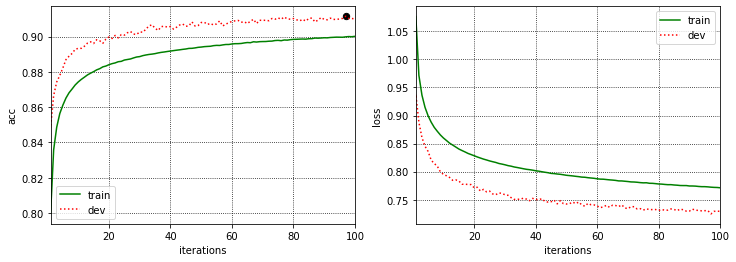

max train acc: 0.9001469387755102
max dev acc: 0.9115333333333333 at epoch 97
corresponding train acc: 0.899859693877551


In [60]:
plot_sta(sta)

In [62]:
torch.save(sta, './model/trivial_c.pt')

In [61]:
net.eval()   
running_corrects = 0
phase = 'test'
with torch.set_grad_enabled(False):
    for batch in dataloaders[phase]:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = net(inputs)
        top_acc = topk_acc(outputs, labels, 2)
        running_corrects += top_acc
    epoch_acc = running_corrects / dataset_sizes[phase]
epoch_acc

0.9090166666666667

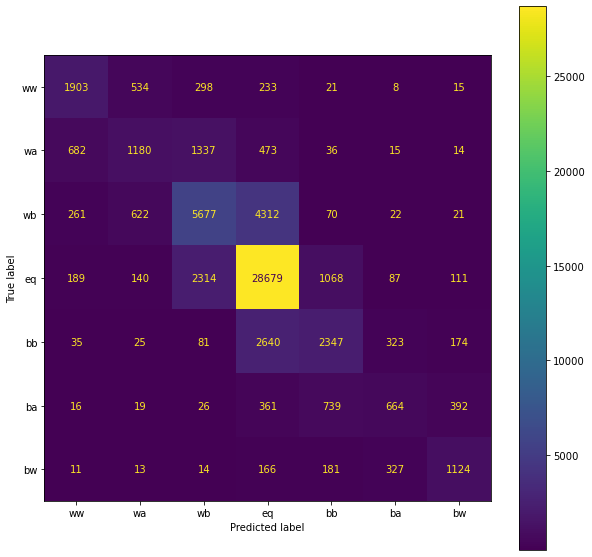

In [52]:
plot_cm(net, dataloaders['test'])